Testing and Exploring with STIM

In [1]:
import stim

In [2]:
c = stim.Circuit("""
    H 0
    CNOT 0 1
    M 0 1
    """)

In [3]:
sampler = c.compile_sampler()

In [4]:
sampler.sample(10)

array([[ True,  True],
       [False, False],
       [ True,  True],
       [False, False],
       [ True,  True],
       [ True,  True],
       [False, False],
       [ True,  True],
       [ True,  True],
       [False, False]])

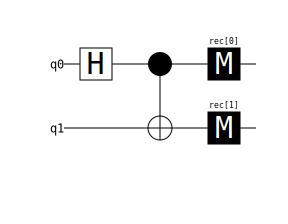

In [5]:
c.diagram("timeline-svg")

In [6]:
def rep_code(distance, rounds, noise):
    circuit = stim.Circuit()
    qbuits = range(2 * distance + 1)
    data = qbuits[::2]
    measure = qbuits[1::2]
    for r in range(rounds):
        for m in measure:
            circuit.append("CNOT", [m - 1, m])
            circuit.append_operation("DEPOLARIZE2", [m-1, m], noise)
        for m in measure:
            circuit.append("CNOT", [m + 1, m])
            circuit.append_operation("DEPOLARIZE2", [m+1, m], noise)
        circuit.append_operation("DEPOLARIZE1", qbuits, noise)
        circuit.append_operation("MR", measure)
        if r > 0:
            for k in range(len(measure)):
                circuit.append_operation("DETECTOR", 
                                        [stim.target_rec(-1-k), 
                                         stim.target_rec(-1-k-distance)])
    circuit.append_operation("M", data)
    for k in range(len(measure)):
        circuit.append_operation("DETECTOR", 
                                [stim.target_rec(-1-k), 
                                 stim.target_rec(-2-k),
                                 stim.target_rec(-2-k-distance)])
    circuit.append_operation("OBSERVABLE_INCLUDE", [stim.target_rec(-1)], 0)
    return circuit

In [7]:
rep_code(distance=3, rounds=2, noise=0.01) 

stim.Circuit('''
    CX 0 1
    DEPOLARIZE2(0.01) 0 1
    CX 2 3
    DEPOLARIZE2(0.01) 2 3
    CX 4 5
    DEPOLARIZE2(0.01) 4 5
    CX 2 1
    DEPOLARIZE2(0.01) 2 1
    CX 4 3
    DEPOLARIZE2(0.01) 4 3
    CX 6 5
    DEPOLARIZE2(0.01) 6 5
    DEPOLARIZE1(0.01) 0 1 2 3 4 5 6
    MR 1 3 5
    CX 0 1
    DEPOLARIZE2(0.01) 0 1
    CX 2 3
    DEPOLARIZE2(0.01) 2 3
    CX 4 5
    DEPOLARIZE2(0.01) 4 5
    CX 2 1
    DEPOLARIZE2(0.01) 2 1
    CX 4 3
    DEPOLARIZE2(0.01) 4 3
    CX 6 5
    DEPOLARIZE2(0.01) 6 5
    DEPOLARIZE1(0.01) 0 1 2 3 4 5 6
    MR 1 3 5
    DETECTOR rec[-1] rec[-4]
    DETECTOR rec[-2] rec[-5]
    DETECTOR rec[-3] rec[-6]
    M 0 2 4 6
    DETECTOR rec[-1] rec[-2] rec[-5]
    DETECTOR rec[-2] rec[-3] rec[-6]
    DETECTOR rec[-3] rec[-4] rec[-7]
    OBSERVABLE_INCLUDE(0) rec[-1]
''')

In [8]:
def shot(circuit, distance, rounds):
    sample = circuit.compile_sampler().sample(1)[0]
    for r in range(rounds):
        print("".join("1" if e else "_" for e in sample[r*distance:(r+1)*distance]))
    print("".join("1" if e else "_" for e in sample[rounds*distance:]))

def shot_detect(circuit, distance, rounds):
    sample = circuit.compile_detector_sampler().sample(1, append_observables=True)[0]
    for r in range(rounds):
        print("".join("1" if e else "_" for e in sample[r*distance:(r+1)*distance]))
    print("".join("1" if e else "_" for e in sample[rounds*distance:]))

In [9]:
d = 80
r = 20
shot(rep_code(distance=d, rounds=r, noise=0.01), distance=d, rounds=r)
print("\n"*3)
shot_detect(rep_code(distance=d, rounds=r, noise=0.01), distance=d, rounds=r)

_______________________________________________1__________________11____________
1______________________11_____________________1_____1_____________11____________
1______________________11____________________________1________1___11____________
1______________________11____11___________________________________11____________
1_1____________________1111__11_____________1_____________________11____________
1______________________1111__11_____________11____________________11____________
1______________________1111__11_____________11____________________11____1_______
1______11______________1111__11_____________11____11____1___1_____11____________
1______11______________1111__11______11_____1111__11____1_________11____________
1______11____11________1111__11______11_____1111__11____11________11____11______
1______11____11________1111__11______11_____1111__11____11________11____11______
1______11____11__________11__11______11_____1111__11____11________11____11___1__
1______11____11__________11_

In [10]:
s = rep_code(distance=10**2, rounds=10**4, noise=0.01).compile_detector_sampler().sample_bit_packed(256)

In [11]:
s

array([[ 13,   0,   2, ...,   0,  96,   0],
       [  0,   0, 128, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   8,   0],
       ...,
       [  0,   1,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  2,   0,   0, ...,   0,  16,   4]], dtype=uint8)